In [1]:
import os
import sys
            
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

#### Data

In [2]:
from input_data import load_los_data, train_test_split, scale_data, sequence_data_preparation

In [3]:
data, adj = load_los_data('los')

In [4]:
time_len = data.shape[0]
num_nodes = data.shape[1]
print("Timesteps:",time_len, "\nSegments:", num_nodes)

Timesteps: 2016 
Segments: 207


#### Train/test split

In [5]:
train_rate = 0.8
train_data, test_data = train_test_split(data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (1612, 207)
Test data:  (404, 207)


#### Scaling

In [6]:
train_scaled, test_scaled = scale_data(train_data, test_data)

### Sequence data perparation for LSTM

* Each training observation are 10 historical speeds.
*Each training prediction is the speed 30 minutes later.

In [7]:
seq_len = 10
pre_len = 6

In [8]:
trainX, trainY, testX, testY = sequence_data_preparation(seq_len, pre_len, train_scaled, test_scaled)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1597, 10, 207)
(1597, 207)
(389, 10, 207)
(389, 207)


In [9]:
from stellargraph.layer import Graph_Convolution_LSTM

In [10]:
gcn_lstm_model = Graph_Convolution_LSTM(num_nodes, adj)

In [11]:
gcn_lstm_model.compile(optimizer = "adam", loss = 'mae', metrics = ['mse'])

In [12]:
history = gcn_lstm_model.fit(trainX,trainY,epochs = 200, batch_size = 60, verbose = 1, validation_data = [testX,testY])

Train on 1597 samples, validate on 389 samples
Epoch 1/200
1597/1597 [==============================] - 3s 2ms/sample - loss: 0.1899 - mse: 0.0646 - val_loss: 0.1326 - val_mse: 0.0506
Epoch 2/200
1597/1597 [==============================] - 1s 371us/sample - loss: 0.1038 - mse: 0.0323 - val_loss: 0.1064 - val_mse: 0.0412
Epoch 3/200
1597/1597 [==============================] - 1s 369us/sample - loss: 0.0965 - mse: 0.0295 - val_loss: 0.1062 - val_mse: 0.0412
Epoch 4/200
1597/1597 [==============================] - 1s 372us/sample - loss: 0.0927 - mse: 0.0287 - val_loss: 0.1056 - val_mse: 0.0411
Epoch 5/200
1597/1597 [==============================] - 1s 373us/sample - loss: 0.0910 - mse: 0.0284 - val_loss: 0.1046 - val_mse: 0.0404
Epoch 6/200
1597/1597 [==============================] - 1s 368us/sample - loss: 0.0896 - mse: 0.0279 - val_loss: 0.1052 - val_mse: 0.0410
Epoch 7/200
1597/1597 [==============================] - 1s 373us/sample - loss: 0.0886 - mse: 0.0278 - val_loss: 0.1044 

In [13]:
gcn_lstm_model.summary()

Model: "graph__convolution_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_convolution (GraphConv multiple                  43156     
_________________________________________________________________
graph_convolution_1 (GraphCo multiple                  43156     
_________________________________________________________________
lstm (LSTM)                  multiple                  326400    
_________________________________________________________________
dense (Dense)                multiple                  41607     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
Total params: 454,319
Trainable params: 368,621
Non-trainable params: 85,698
_________________________________________________________________


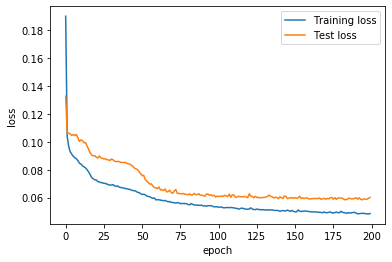

In [14]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [15]:
ythat = gcn_lstm_model.predict(trainX)
yhat = gcn_lstm_model.predict(testX)

In [16]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

train_rescpred=np.array((ythat)*max_speed)
test_rescpred=np.array((yhat)*max_speed)

train_rescref=np.array(trainY*max_speed)
test_rescref=np.array(testY*max_speed)


## Naive prediction benchmark (using previous observed value)

testnpred=np.array(testX).transpose(1,0,2)[-1] #picking the last speed of the 10 sequence for each segment in each sample
#testnpred=np.mean(np.array(test_X).transpose(1,0,2), axis=0)
testnpredc=(testnpred)*max_speed

In [17]:
## Performance measures

seg_mael=[]
seg_masel=[]
seg_nmael=[]

for j in range(testX.shape[-1]):
    
    seg_mael.append(np.mean(np.abs(test_rescref.T[j]-test_rescpred.T[j]))) #Mean Absolute Error for NN
    seg_nmael.append(np.mean(np.abs(test_rescref.T[j]-testnpredc.T[j]))) #Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(seg_mael[-1]/seg_nmael[-1]) #Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)
        
print('Total (ave) MAE for NN: '+str(np.mean(np.array(seg_mael))))
print('Total (ave) MAE for naive prediction: '+str(np.mean(np.array(seg_nmael))))
print('Total (ave) MASE for per-segment NN/naive MAE: '+str(np.nanmean(np.array(seg_masel))))
print('...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.')

Total (ave) MAE for NN: 4.206564492957458
Total (ave) MAE for naive prediction: 4.419344411501992
Total (ave) MASE for per-segment NN/naive MAE: 0.9585430435736008
...note that MASE<1 (for a given segment) means that the NN prediction is better than the naive prediction.


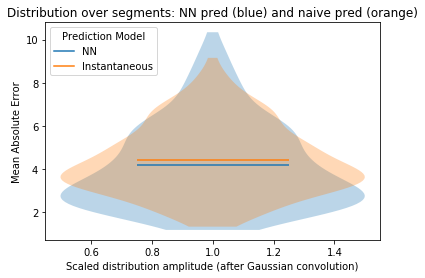

In [18]:
# plot violin plot of MAE for naive and NN predictions
fig, ax = plt.subplots()
#xl = minsl

ax.violinplot(list(seg_mael),
                   showmeans=True,
                   showmedians=False,
              showextrema=False,
             widths=1.0)

ax.violinplot(list(seg_nmael),
                   showmeans=True,
                   showmedians=False,
              showextrema=False,
             widths=1.0)

line1 = mlines.Line2D([], [], label='NN')
line2 = mlines.Line2D([], [],color='C1', label='Instantaneous')

ax.set_xlabel('Scaled distribution amplitude (after Gaussian convolution)')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Distribution over segments: NN pred (blue) and naive pred (orange)')
plt.legend(handles=(line1,line2),title='Prediction Model',loc=2)
plt.show()

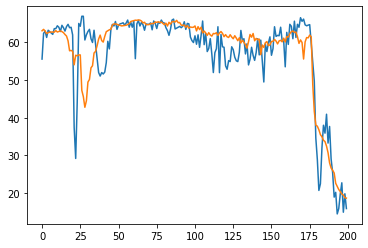

In [19]:
plt.plot(test_rescref[:200,100])
plt.plot(test_rescpred[:200,100])

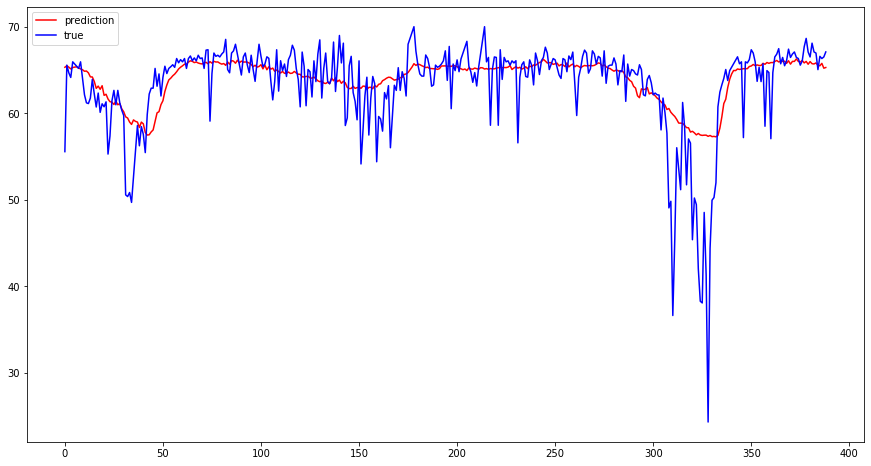

In [20]:
##all test result visualization
fig1 = plt.figure(figsize=(15,8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:,1]
a_true = test_rescref[:,1]
plt.plot(a_pred,'r-',label='prediction')
plt.plot(a_true,'b-',label='true')
plt.legend(loc='best',fontsize=10)
plt.show()